In [1]:
# import libraries

import matplotlib.pyplot as plt
from rdkit.Chem import AllChem as rdkit
import stk
import numpy as np
import MDAnalysis as mda
import pywindow as pw

from scipy.ndimage import gaussian_filter1d
from scipy.spatial import ConvexHull

%matplotlib inline

c:\Users\domin\anaconda3\envs\stk1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Must update the cage and solvent used in the below code cell. Variable names of tritopic_bb, ditopic_bb and cage should be kept the same. Solvent must also be present in the solvent_to_atom_no and solvent_to_smiles dictionaries defined shortly (currently 'DCM', 'MeOH', 'THF' and 'Chloroform' are defined). cage_type should be chosen from '4+6', '6+9' or '8+12'.

In [2]:
# must update solvent, cage type and stk cage building used here
solvent = 'DCM'
cage_type = '4+6'

tritopic_bb = stk.BuildingBlock('C1=C(C=C(C=C1C=O)C=O)C=O', [stk.AldehydeFactory()])
ditopic_bb = stk.BuildingBlock(smiles='N[C@@H]1CCCC[C@H]1N',functional_groups=[stk.PrimaryAminoFactory()],)
cage = stk.ConstructedMolecule(
            topology_graph=stk.cage.FourPlusSix(building_blocks={
                    ditopic_bb: range(4, 10),tritopic_bb: range(0, 4),},optimizer =stk.MCHammer(),),)

In [3]:
def get_reduced_building_block(building_block): 
    '''
    Takes an stk building block and removes deleter atoms, such that later updating of building block 
    position matrix can be done easily on a building block by building block basis.
    
    Inputs:
    building_block: stk building block
    Returns:
    reduced_building_block: stk building block with deleter atoms removed
    '''

    # identify stk ids of deleter atoms by looping through building block functional groups
    deleter_atom_ids = []
    for i in building_block.get_functional_groups():
        deleter_atom_ids.extend(list(i.get_deleter_ids()))

    # create stk atom list containing only non-deleter atoms
    filtered_atoms = [atom for atom in building_block.get_atoms() if atom.get_id() not in deleter_atom_ids]

    # we now need to correct the stk mapping for the filtered atoms
    # make dictionary to hold old_stk_id:new_stk_id mapping
    old_to_new_id = {old_id: new_id for new_id, old_id in enumerate(atom.get_id() for atom in filtered_atoms)}
    # use dictionary to create list containing only non-deleter atoms with fixed stk atom ids
    renumbered_atoms = [atom.with_id(new_id) for atom, new_id in zip(filtered_atoms, old_to_new_id.values())]


    # we now need to correct the stk bonding for the filtered atoms, with only bonds between non-deleted atoms
    # loop through original building block bonds and add non-deleted bonds to new bonding list, with fixed ids
    filtered_bonds = []
    for bond in building_block.get_bonds():
        if bond.get_atom1().get_id() in old_to_new_id and bond.get_atom2().get_id() in old_to_new_id:
            new_bond = stk.Bond(
                atom1=renumbered_atoms[old_to_new_id[bond.get_atom1().get_id()]],  # update atom1 id
                atom2=renumbered_atoms[old_to_new_id[bond.get_atom2().get_id()]],  # update atom2 id
                order=bond.get_order()  # keep the bond order the same
            )
            filtered_bonds.append(new_bond)

    # fix the position matrix to include only the non-deleted atoms 
    original_position_matrix = building_block.get_position_matrix()
    updated_position_matrix = np.array([original_position_matrix[old_id] for old_id in old_to_new_id])

    # construct the new building block with updated atoms, atom ids, bonds, and positions
    reduced_building_block = stk.BuildingBlock.init(
        atoms = renumbered_atoms,
        bonds = filtered_bonds,
        position_matrix = updated_position_matrix)
    
    print("Deleted Atom IDs:", deleter_atom_ids)
    print("Original Atom Count:", len(list(building_block.get_atoms())))
    print("Filtered Atom Count:", len(list(reduced_building_block.get_atoms())))
    print("Original Bond Count:", len(list(building_block.get_bonds())))
    print("Filtered Bond Count:", len(list(reduced_building_block.get_bonds())))
    print("New Atom ID Mapping:", old_to_new_id)

    return reduced_building_block

If using more than 2 types of building blocks, the below code will need to be adapted. The order of list appending in defining building_blocks below also needs to be in the same order as defined when first constructing the cage above. Here it is based on tritopic building block followed by ditopic building blocks; eg: during cage building, building blocks: {ditopic_bb: range(8, 20),tritopic_bb: range(0, 8)}.

In [4]:
# load the system to MDanalysis universe. update parameters if needed.
u = mda.Universe("lammps_files/lammps_input_data.data", "lammps_files/lammps_output_lammpstrj.lammpstrj", format="LAMMPSDUMP", lammps_coordinate_convention="scaled", dt=1)
no_frames = len(u.trajectory)
sim_length = 10 # simulation length
time_data = (np.array(range(0, no_frames)) / ((no_frames-1)/sim_length)).tolist() # setup x axis list for plots
no_solvent_molecules = len(u.residues) - 1
no_atoms_in_cage = len(u.select_atoms("resid 1"))
solvent_to_atom_no = {'DCM':5,'MeOH':6,'THF':13,'Chloroform':5}
no_atoms_in_solvent = solvent_to_atom_no[solvent]
solvent_to_smiles = {'DCM':'C(Cl)Cl','MeOH':'CO','THF':'C1CCOC1','Chloroform':'C(Cl)(Cl)Cl'}

cage_file_name = 'data_storage/data_cage_only_unwrapped.xyz'
solvents_file_name = 'data_storage/data_solvent_only_unwrapped.xyz'
solvents = [stk.BuildingBlock(solvent_to_smiles[solvent]) for _ in range(no_solvent_molecules)]

no_tritopic_bb = cage.get_num_building_block(tritopic_bb)
no_ditopic_bb = cage.get_num_building_block(ditopic_bb)
no_building_blocks = no_ditopic_bb + no_tritopic_bb
building_blocks = [get_reduced_building_block(tritopic_bb) for _ in range(no_tritopic_bb)] + [get_reduced_building_block(ditopic_bb) for _ in range(no_ditopic_bb)]

Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Deleted Atom IDs: [11, 9, 7]
Original Atom Count: 18
Filtered Atom Count: 15
Original Bond Count: 18
Filtered Bond Count: 15
New Atom ID Mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 8: 7, 10: 8, 12: 9, 13: 10, 14: 11, 15: 12, 16: 13, 17: 14}
Dele

In [5]:
def get_cage_frame_data(file_name, frame_number):
    '''
    Outputs the position matrix of the cage for a given frame.

    Inputs:
    file_name (str): path to the cage only unwrapped file
    frame_number (int): the frame to be extracted
    Returns:
    frame_data (list): list[cage_atom][coorindates] containing cage position information
    '''
    # open file and setup counts and conditions
    datafile = open(file_name, 'r')
    line_count = 0
    frame_count = 0 # count of lines after frame has been identified
    frame_id = False
    frame_data = [] # empty list to store cage frame information

    # loop through each line
    for line in datafile:

        # define number of atoms in cage on first line of file
        if line_count == 0:
            frame_atoms_range = range(0,int(line))
        line_count = line_count + 1

        # when condition is true, extract frame coordinates
        if frame_id == True:
            if frame_count in frame_atoms_range:
                line = line.split()
                frame_data.extend([[float(x) for x in line[1:]]])
            frame_count = frame_count + 1
        
        # set condition to true when the desired frame is encountered
        if line == f"frame {frame_number}\n":
            frame_id = True
    return frame_data

In [6]:
#adapted code to output position matrix of each solvent for specific frame, given frame data of solvents (no cage)
def get_solvent_frame_data(file_name,frame_number,no_solvent_molecules,no_atoms_in_solvent):
    '''
    Outputs the position matrix of the solvent for a given frame.

    Inputs:
    file_name (str): path to the cage only unwrapped file
    frame_number (int): the frame to be extracted
    no_solvent_molecules (int): the number of solvent molecules
    no_atoms_in_solvent (int): the number of atoms per solvent molecule
    Returns:
    frame_data (list): list[solvent molecule][solvent atom][coorindates] containing cage position information
    '''
    # open file and setup counts and conditions
    datafile = open(file_name, 'r')
    frame_count = 0 # count of lines after frame has been identified
    frame_id = False
    frame_data = [[] for _ in range(no_solvent_molecules)]
    solvent_atom_count = 0
    solvent_molecule_count = 0
    frame_length = range(0,no_solvent_molecules*no_atoms_in_solvent)

    # loop through each line
    for line in datafile:

        # when condition is true, extract atom coordinates and append to relevant solvent's sublist
        if frame_id == True:
            if frame_count in frame_length:
                line = line.split()
                frame_data[solvent_molecule_count].extend([[float(x) for x in line[1:]]])
            frame_count = frame_count + 1
            solvent_atom_count = solvent_atom_count + 1
            if solvent_atom_count == no_atoms_in_solvent:
                solvent_atom_count = 0
                solvent_molecule_count = solvent_molecule_count + 1
        
        # set condition to true when the desired frame is encountered
        if line == f"frame {frame_number}\n":
            frame_id = True
        
    return frame_data

In [7]:
def euclidean_distance(a,b):
    '''
    Calculates distance between two points.
    
    Inputs:
    a,b (list): lists representing points a/b, with x,y,z coordinate information
    Returns:
    distance (float): the distance between the two points    
    '''
    distance = ( (a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 )**0.5
    return distance

In [8]:
def convex_hull_volume(bb_com_data, no_frames):
    '''
    Outputs convex hull volume data of 3D shape defined by the centres of masses of input building blocks.
    
    Inputs:
    bb_com_data (list): list[no_bbs][no_frames][coorindates] containing the building block centre of mass data
    no_frames (int): number of frames in the simulation
    Returns:
    frame_volumes (list): list of the convex hull volumes for each frame
    '''
    frame_volumes = []  # setup list to store volume for each frame
    
    # loop through each frame, obtain centre of mass data, calculate convex hull and get volume
    for frame_number in range(no_frames):
        com_positions = np.array([bb_com_data[bb][frame_number] for bb in range(len(bb_com_data))])
        volume = ConvexHull(com_positions).volume
        frame_volumes.append(volume)

    return frame_volumes

In [9]:
def get_ch_threshold_volume(cage_type, ch_volume, frame_number):
    '''
    Outputs the convex hull threshold volume for a given cage type, when given the convex hull volume data and frame number.
    
    Inputs:
    cage_type (str): string of '4+6', '6+9' or '8+12' defining the cage topology
    ch_volume (list): list of frame by frame convex hull volumes for each frame
    frame_number (int): the frame number
    Returns:
    ch_threshold_volume (int): the threshold volume for the given cage type and frame
    '''
    if cage_type == '4+6':
        ch_threshold_volume = ((ch_volume[frame_number])/(8*(3**0.5)))**(1/3)
    elif cage_type == '6+9':
        ch_threshold_volume = ((3*(ch_volume[frame_number]))/(4*np.pi))**(1/3)
    elif cage_type == '8+12':
        ch_threshold_volume = 0.5*((ch_volume[frame_number])**(1/3))
    elif cage_type == 'test':
        ch_threshold_volume = (ch_volume[frame_number])**(1/3)

    return ch_threshold_volume

In [10]:
# code to store centres of masses (com) of cage and coms of solvent for each frame as lists of shape 
# [no_frames][coordinates] and [no_solvent_molecules][no_frames][coordinates] respectively

# setup lists to store com data
cage_com_data = []
solvents_com_data = [[] for _ in range(no_solvent_molecules)]

# loop each frame, extracting cage and solvent frame data
for frame_number in range(0,no_frames):
    cage_frame_data = np.array(get_cage_frame_data(cage_file_name,frame_number))
    solvents_frame_data = np.array(get_solvent_frame_data(solvents_file_name,frame_number,no_solvent_molecules,no_atoms_in_solvent))
    
    # loop through each molecule
    for i in range(-1,no_solvent_molecules):
        # identify the cage and extract cage com information
        if i == -1:
            cage = cage.with_position_matrix(cage_frame_data) # change cage position matrix
            rdkit_mol = cage.to_rdkit_mol()
            molsys = pw.MolecularSystem.load_rdkit_mol(rdkit_mol)
            mol = molsys.system_to_molecule()
            cage_com_data.extend([mol.calculate_centre_of_mass()])
        
        # indentify solvents and extract solvent com to relevant solvent's sublist
        else:
            solvents[i] = solvents[i].with_position_matrix(solvents_frame_data[i]) # change solvent position matrix
            rdkit_mol = solvents[i].to_rdkit_mol()
            molsys = pw.MolecularSystem.load_rdkit_mol(rdkit_mol)
            mol = molsys.system_to_molecule()
            solvents_com_data[i].extend([mol.calculate_centre_of_mass()])


In [11]:
# code to store tritopic building block centres of masses (com) for each frame as a list of 
# shape [no_tritopic_bbs][no_frames][coordinates]
# also outputs an .xyz file of the coms for easy visualisation. Each building block is represented as an H atom 
# at its com

tritopic_bb_com_data = [[] for _ in range(no_tritopic_bb)] # setup list for each tritopic building block

with open('data_storage/coms_tritopic_bbs.xyz', 'w') as f:
    for frame_number in range(0,no_frames): # loop through each frame
        f.write(f"{no_tritopic_bb}\n") # write number of tritopic building blocks
        f.write(f"frame {frame_number}\n") # write frame number

        cage_frame_data = np.array(get_cage_frame_data(cage_file_name,frame_number)) # obtain cage position matrix for specified frame

        # loop through each tritopic building block, extract relevant atomic coordinates and calculate com
        for bb_number in range(0,no_tritopic_bb):
            no_atoms_in_bb = building_blocks[bb_number].get_num_atoms() # define number of atoms in building block
            upper_index = (bb_number+1)*no_atoms_in_bb # define region in which building block data resides within cage_frame_data        
            bb_frame_data = cage_frame_data[upper_index - no_atoms_in_bb:upper_index] # get building block position matrix

            # update building block position matrix and calculate com
            building_blocks[bb_number] = building_blocks[bb_number].with_position_matrix(bb_frame_data)
            rdkit_mol = building_blocks[bb_number].to_rdkit_mol()
            molsys = pw.MolecularSystem.load_rdkit_mol(rdkit_mol)
            mol = molsys.system_to_molecule()
            com = mol.calculate_centre_of_mass()
            tritopic_bb_com_data[bb_number].extend([com])

            f.write(f"H {com[0]:.3f} {com[1]:.3f} {com[2]:.3f}\n")


In [12]:
# code to calculate both pywindow (pw) and convex hull (ch) volumes for each frame, storing values in lists
ch_volume = convex_hull_volume(tritopic_bb_com_data, no_frames)

pw_volume = [] # setup empty list to store pywindow volumes

# loop through frames, extract cage atomic positions and calculat pw pore volume
for frame_number in range(0,no_frames):
    cage = cage.with_position_matrix(np.array(get_cage_frame_data('data_storage/data_cage_only_unwrapped.xyz',frame_number))) # update position matrix
    rd = cage.to_rdkit_mol()
    molsys = pw.MolecularSystem.load_rdkit_mol(rd)
    mol = molsys.system_to_molecule()
    pw_volume.extend([mol.calculate_pore_volume()])

# change any negative pw values to zero to avoid negative volumes and possible future calculation issues
for i in range(len(pw_volume)):
    if pw_volume[i] < 0:
        pw_volume[i] = 0

For the following code, a solvent is defined as being 'inside' the cage if its com is within a defined sphere, centered on the cage com. The radius (threshold) of said sphere is:

1) For the pw volume definition, simply the radius of the sphere defined by pw to begin with
2) For the ch definition, the radius of sphere that perfectly fits inside the 'tetrahedron'/'cube' shape outlined by the tritopic building blocks for [4+6]/[8+12] shape. Note this approximation of a sphere that perfectly fits within a 'tetrahedron'/'cube' could break down later in the simulation in cases where the terahedral/cubic shape breaks down, though it should still work for the overall purposes of the script.
3) For ch volume of [6+9] cages, since this is not a platonic solid, a simple defintion was adopted: the radius used was simply the radius of the sphere defined by the ch volume (aka assuming that the ch volume is spherical).

In [13]:
# This code stores the number of solvents determined to be 'inside' the cage for each frame based on either
# pw or ch volume definitions.

pw_solvents_in_count = 0
ch_solvents_in_count = 0
pw_no_solvents_in_cage = [] # list to store no of solvents defined as being within cage based on pywindow volume
ch_no_solvents_in_cage = [] # list to store no of solvents defined as being within cage based on convex hull volume

# loop through frames
for frame_number in range(0,no_frames):
    # obtain cage com
    centre_of_cage = cage_com_data[frame_number]

    # loop through solvent and compare solvent com to cage com
    for solvent_number in range(0,no_solvent_molecules):
        solvent_com = solvents_com_data[solvent_number][frame_number]
        distance = euclidean_distance(centre_of_cage,solvent_com)

        # if within threshold, increase solvents inside cage count
        if distance < ((3*(pw_volume[frame_number]))/(4*np.pi))**(1/3):
            pw_solvents_in_count = pw_solvents_in_count + 1
        if distance < get_ch_threshold_volume(cage_type,ch_volume, frame_number):
            ch_solvents_in_count = ch_solvents_in_count + 1
        
        if solvent_number == no_solvent_molecules-1:
            pw_no_solvents_in_cage.extend([pw_solvents_in_count])
            ch_no_solvents_in_cage.extend([ch_solvents_in_count])
    pw_solvents_in_count = 0
    ch_solvents_in_count = 0

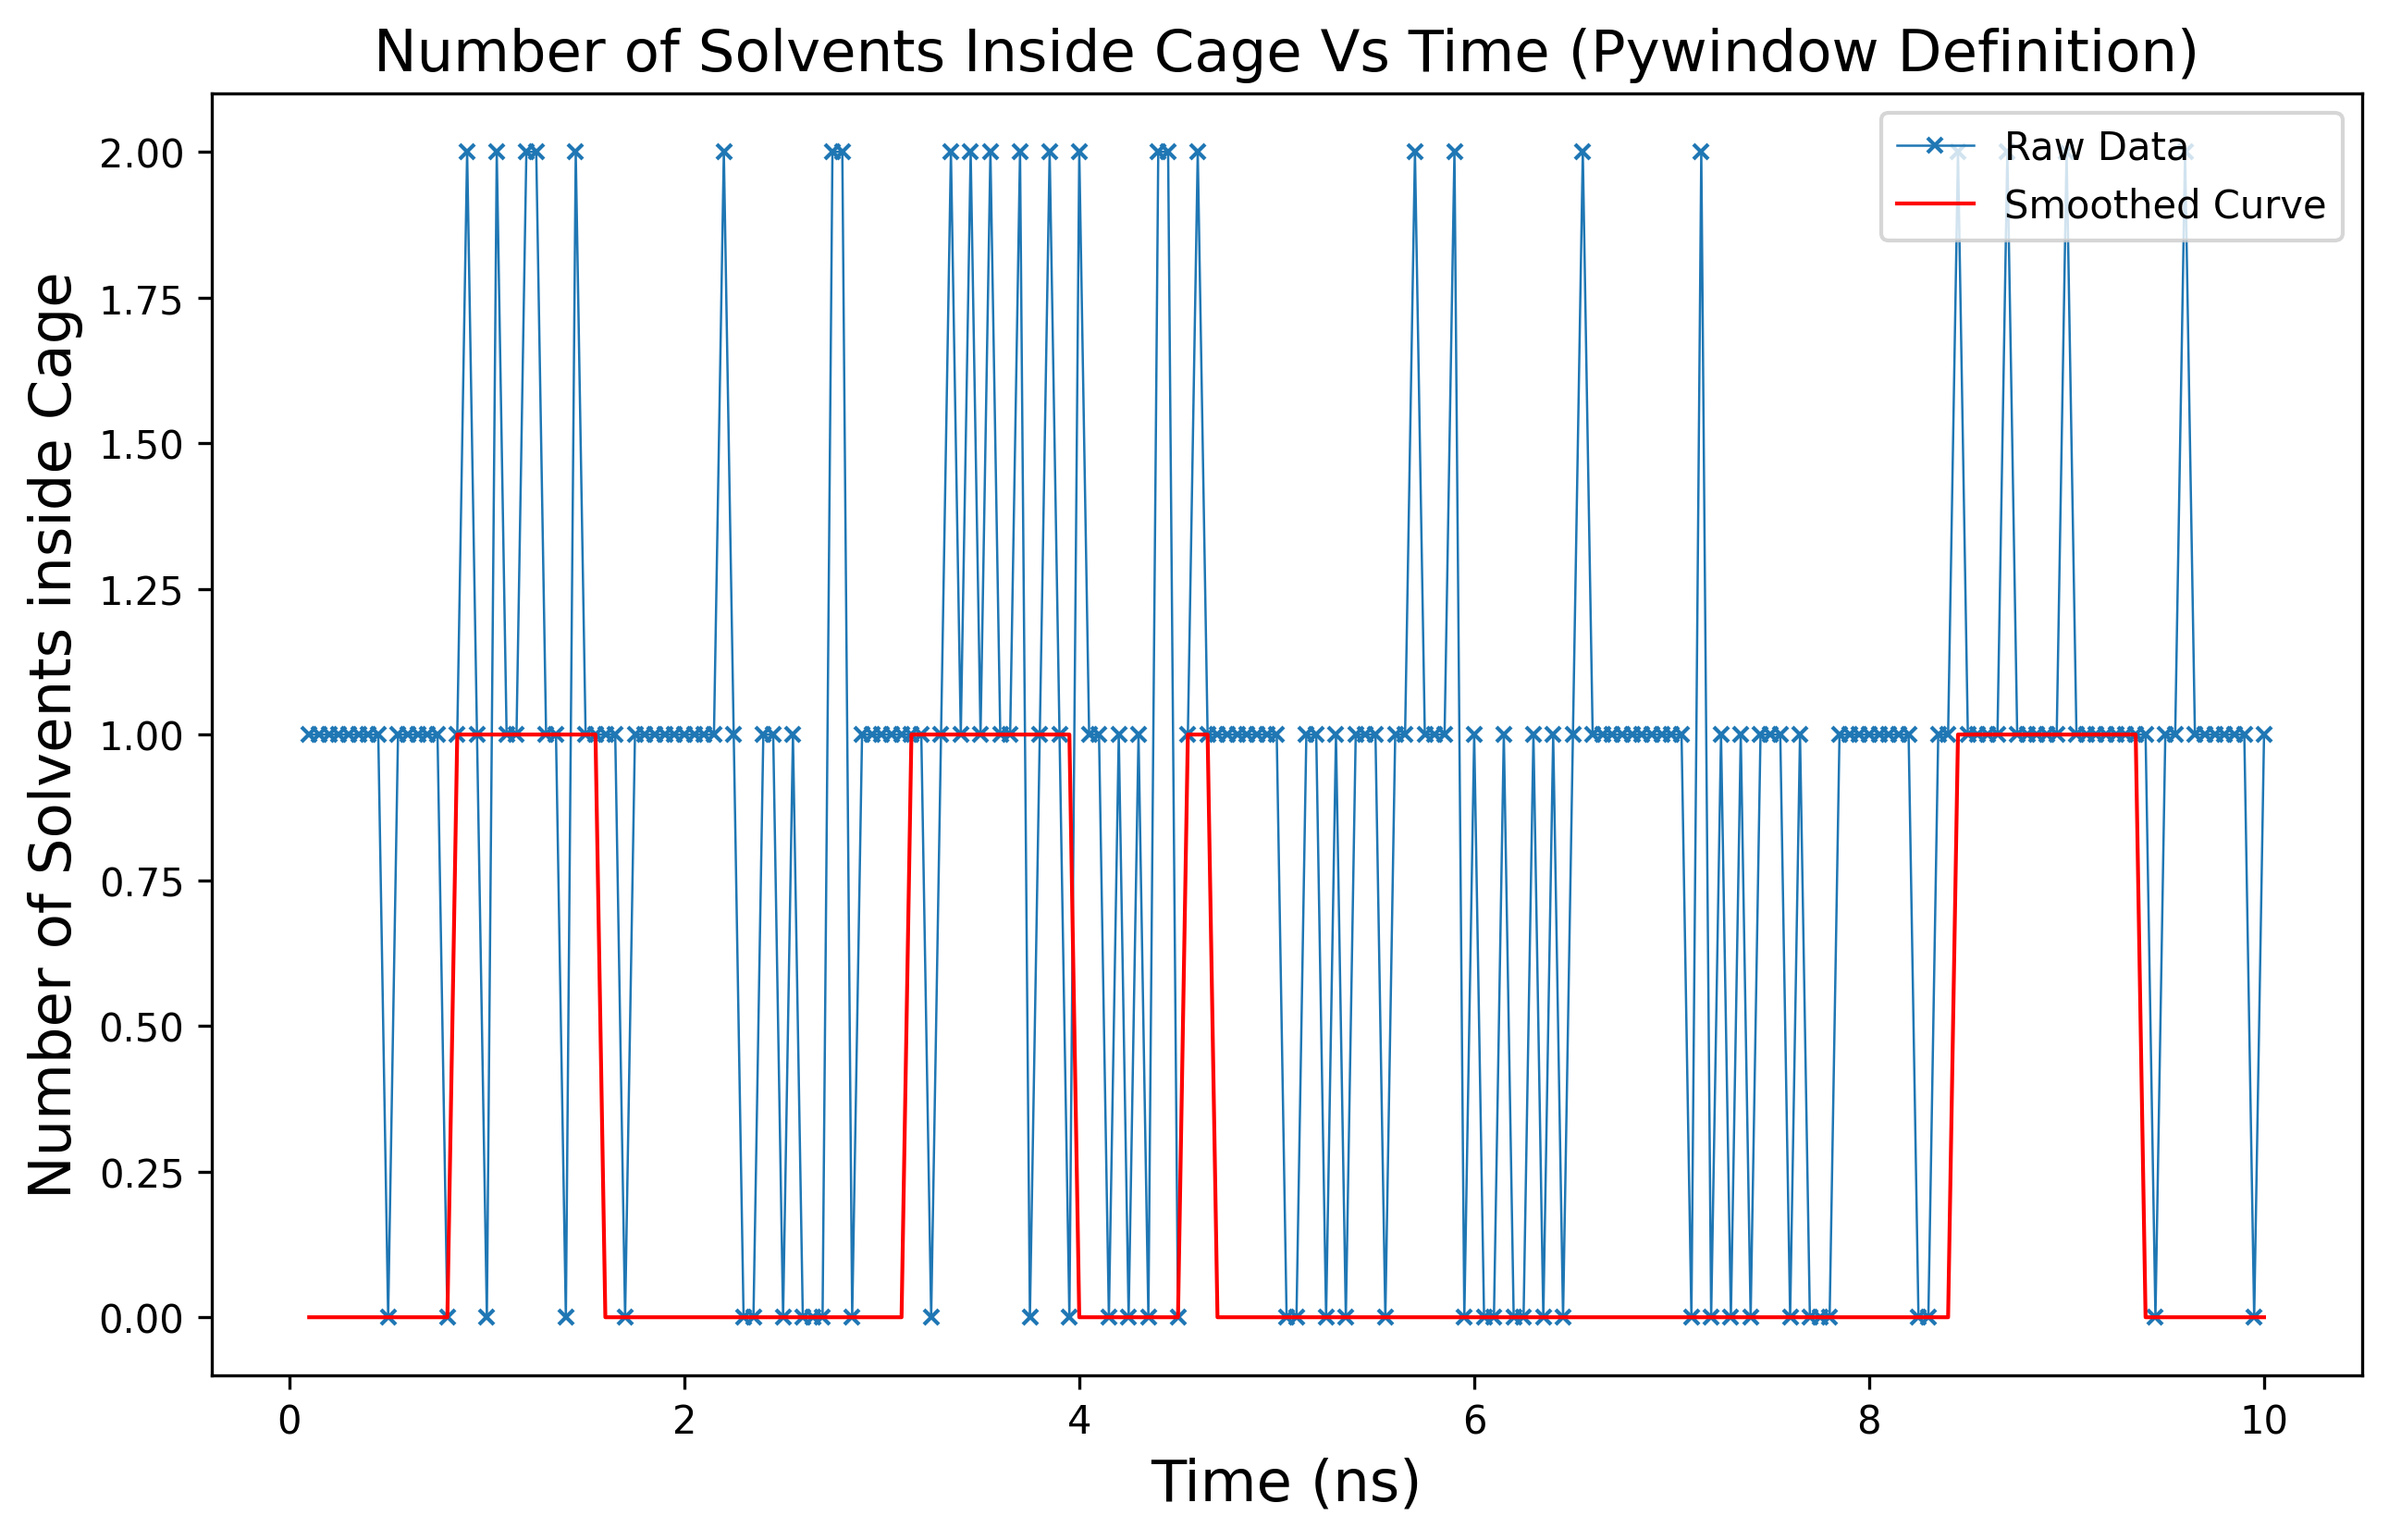

In [14]:
plt.figure(figsize=[10,6],dpi=300)
pw_no_solvents_in_cage_smooth = gaussian_filter1d(pw_no_solvents_in_cage[2:], sigma=5)  # increase sigma for more smoothing
plt.plot(time_data[2:], pw_no_solvents_in_cage[2:], linestyle='-', marker='x',linewidth=0.6, markersize=4, label = 'Raw Data') # plot raw data
plt.plot(time_data[2:], pw_no_solvents_in_cage_smooth, linewidth=1, color='red', label='Smoothed Curve') # plot gausian smoothed curve
plt.title('Number of Solvents Inside Cage Vs Time (Pywindow Definition)', fontsize=15)
plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel('Number of Solvents inside Cage', fontsize=15)
plt.legend()
plt.show()

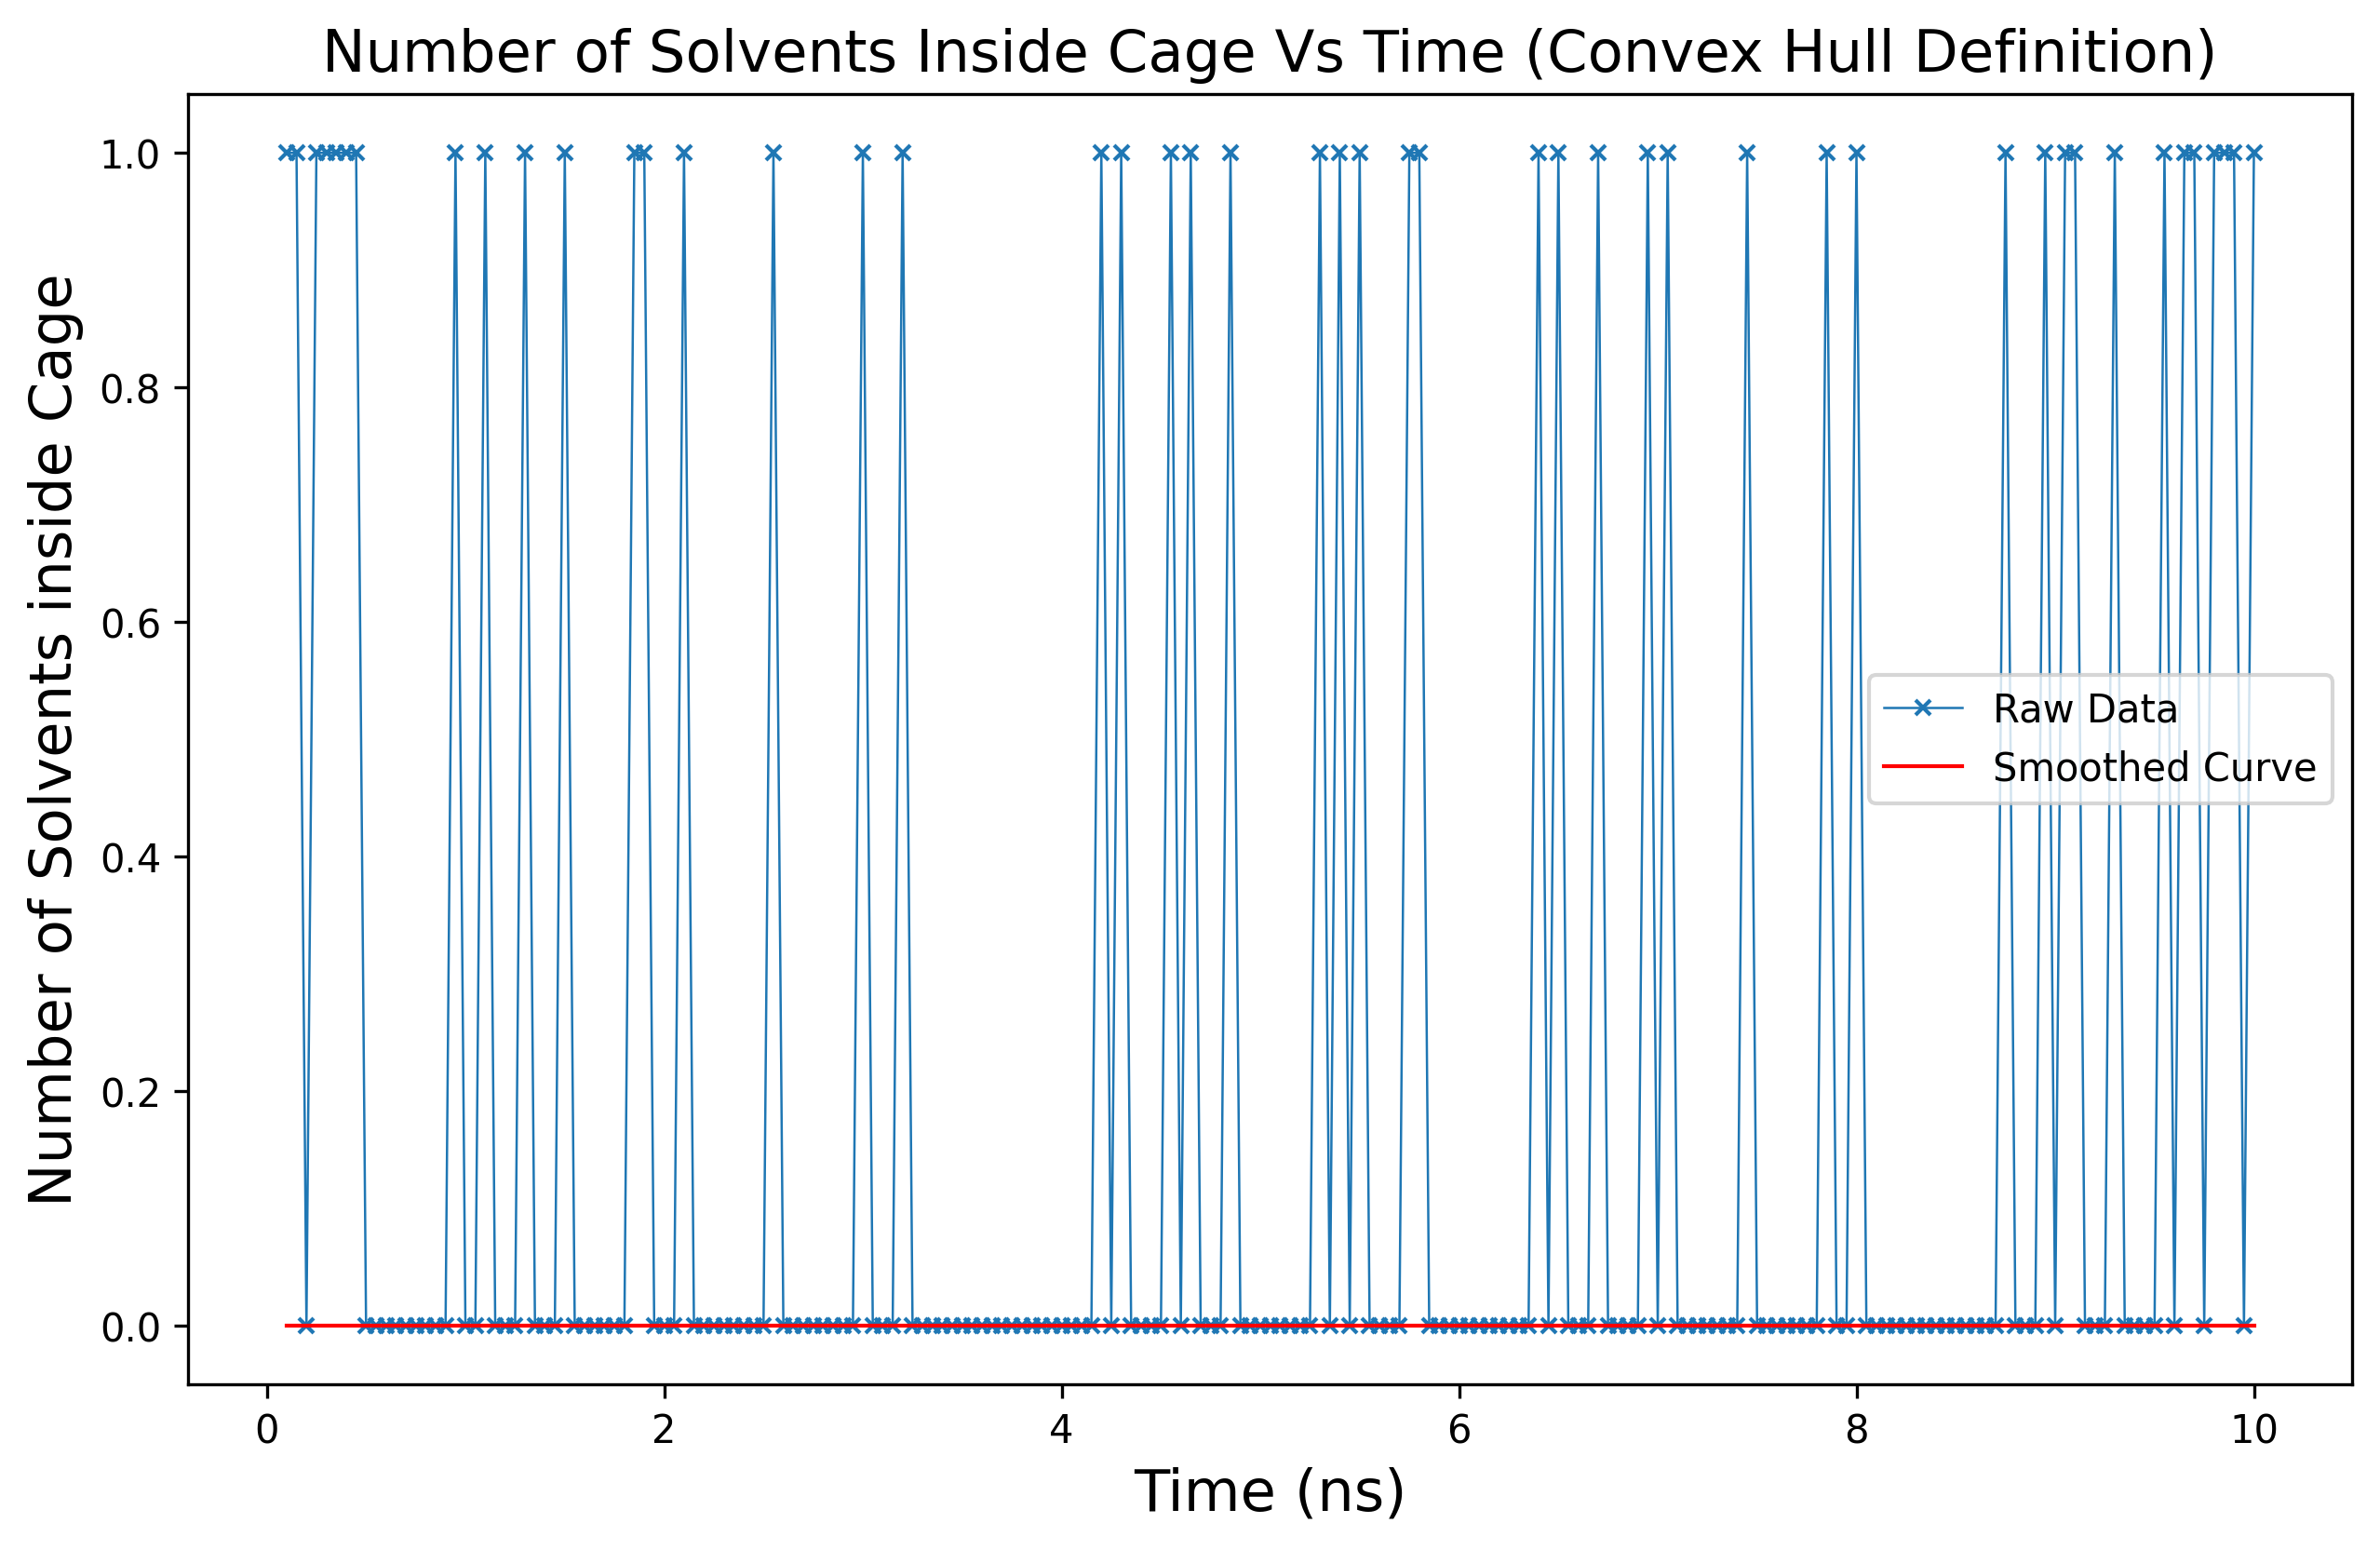

In [15]:
plt.figure(figsize=[10,6],dpi=300)
ch_no_solvents_in_cage_smooth = gaussian_filter1d(ch_no_solvents_in_cage[2:], sigma=5)  # increase sigma for more smoothing
plt.plot(time_data[2:], ch_no_solvents_in_cage[2:], linestyle='-', marker='x',linewidth=0.6, markersize=4, label = 'Raw Data') # plot raw data
plt.plot(time_data[2:], ch_no_solvents_in_cage_smooth, linewidth=1, color='red', label='Smoothed Curve') # plot gausian smoothed curve
plt.title('Number of Solvents Inside Cage Vs Time (Convex Hull Definition)', fontsize=15)
plt.xlabel("Time (ns)", fontsize=15)
plt.ylabel('Number of Solvents inside Cage', fontsize=15)
plt.legend()
plt.show()

In [16]:
# code to track solvent hopping rates (transitions between 'in' and 'out' of cage per second) based on pw volumes

hopping_counts = {solvent: 0 for solvent in range(no_solvent_molecules)}  # dictionary to store total number of transitions for each solvent (transition == switch between inside/outside cage)
last_state = {solvent: None for solvent in range(no_solvent_molecules)}  # dictionary to store the last state of each solvent (inside/outside cage)

# loop through frames (ignore first two frames for hopping rate calculations)
for frame_number in range(2,no_frames):
    centre_of_cage = cage_com_data[frame_number]
    
    # loop through solvent molecules and evaluate if solvent is 'in' cage
    for solvent_number in range(no_solvent_molecules):
        solvent_com = solvents_com_data[solvent_number][frame_number]
        distance = euclidean_distance(centre_of_cage, solvent_com)

        # use first evaluated frame to define initial solvent states (inside or outside cage)
        if frame_number == 2:
            if distance < ((3*(pw_volume[frame_number]))/(4*np.pi))**(1/3): # use pw definition
                last_state[solvent_number] = 'inside'
            else:
                last_state[solvent_number] = 'outside'

        # for remaining frames, evaluate as normal
        else:
            if distance < ((3*(pw_volume[frame_number]))/(4*np.pi))**(1/3): # use pw definition
                if last_state[solvent_number] == 'outside': # outside to inside transition
                    hopping_counts[solvent_number] += 1  # count transition
                    last_state[solvent_number] = 'inside' # update solvent state
            else: 
                if last_state[solvent_number] == 'inside': # inside to outside transition
                    hopping_counts[solvent_number] += 1  # count transition
                    last_state[solvent_number] = 'outside' # update solvent state

# print outputs
print('Pywindow based solvent hopping rates')
for solvent_number in range(no_solvent_molecules):
    if hopping_counts[solvent_number] != 0:
        print(f'Solvent {solvent_number}:','Hopping Rate:',hopping_counts[solvent_number]/9.9,'transitions per ns')

Pywindow based solvent hopping rates
Solvent 0: Hopping Rate: 0.6060606060606061 transitions per ns
Solvent 4: Hopping Rate: 0.6060606060606061 transitions per ns
Solvent 13: Hopping Rate: 0.8080808080808081 transitions per ns
Solvent 14: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 15: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 23: Hopping Rate: 2.0202020202020203 transitions per ns
Solvent 30: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 32: Hopping Rate: 0.8080808080808081 transitions per ns
Solvent 35: Hopping Rate: 0.40404040404040403 transitions per ns
Solvent 37: Hopping Rate: 0.40404040404040403 transitions per ns
Solvent 41: Hopping Rate: 0.40404040404040403 transitions per ns
Solvent 42: Hopping Rate: 1.0101010101010102 transitions per ns
Solvent 55: Hopping Rate: 0.10101010101010101 transitions per ns
Solvent 57: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 62: Hopping Rate: 1.4141414141414141 transitions per 

In [17]:
# code to track solvent hopping rates (transitions between 'in' and 'out' of cage per second) based on ch volumes

hopping_counts = {solvent: 0 for solvent in range(no_solvent_molecules)}  # dictionary to store total number of transitions for each solvent (transition == switch between inside/outside cage)
last_state = {solvent: None for solvent in range(no_solvent_molecules)}  # dictionary to store the last state of each solvent (inside/outside cage)

# loop through frames (ignore first two frames for hopping rate calculations)
for frame_number in range(2,no_frames):
    centre_of_cage = cage_com_data[frame_number]

    # loop through solvent molecules and evaluate if solvent is 'in' cage
    for solvent_number in range(no_solvent_molecules):
        solvent_com = solvents_com_data[solvent_number][frame_number]
        distance = euclidean_distance(centre_of_cage, solvent_com)

        # use first evaluated frame to define initial solvent states (inside or outside cage)
        if frame_number == 2:
            if distance < get_ch_threshold_volume(cage_type,ch_volume, frame_number): # use ch definition
                last_state[solvent_number] = 'inside'
            else:
                last_state[solvent_number] = 'outside'
        
        # for remaining frames, evaluate as normal
        else:
            if distance < get_ch_threshold_volume(cage_type,ch_volume, frame_number): # use ch definition
                if last_state[solvent_number] == 'outside': # outside to inside transition
                    hopping_counts[solvent_number] += 1  # count transition
                    last_state[solvent_number] = 'inside' # update solvent state
            else: 
                if last_state[solvent_number] == 'inside': # inside to outside transition
                    hopping_counts[solvent_number] += 1  # count transition
                    last_state[solvent_number] = 'outside' # update solvent state

# print outputs
print('Convex hull based solvent hopping rates')
for solvent_number in range(no_solvent_molecules):
    if hopping_counts[solvent_number] != 0:
        print(f'Solvent {solvent_number}:','Hopping Rate:',hopping_counts[solvent_number]/9.9,'transitions per ns')

Convex hull based solvent hopping rates
Solvent 0: Hopping Rate: 0.40404040404040403 transitions per ns
Solvent 4: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 13: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 15: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 23: Hopping Rate: 0.6060606060606061 transitions per ns
Solvent 32: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 35: Hopping Rate: 0.40404040404040403 transitions per ns
Solvent 37: Hopping Rate: 0.40404040404040403 transitions per ns
Solvent 55: Hopping Rate: 0.10101010101010101 transitions per ns
Solvent 62: Hopping Rate: 0.40404040404040403 transitions per ns
Solvent 77: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 82: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 96: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 97: Hopping Rate: 0.20202020202020202 transitions per ns
Solvent 110: Hopping Rate: 0.30303030303030304 transi

Remaining code cells work towards the output of .xyz files for simpe visualisation of the cage and solvents represented by a single Cu atom at the solvent's centre of mass.

In [18]:
def extract_atom_types(file_name, atomic_masses):
    '''
    Defines a mapping from LAMMPS atom types to chemical atom names from input LAMMPS .data file
    
    Inputs:
    file_name (str): path to the file
    atomic_masses (dict): dictionary contaning mass information for each chemical atom

    Returns:
    type_to_name (dict): dictionary mapping LAMMPS atom types to chemical atom name
    '''
    type_to_name = {}
    
    # open LAMMPS data file and read lines
    with open(file_name, 'r') as file:
        lines = file.readlines()

    # finding indexes for beginning and end of masses section of input .data file
    for i in range(len(lines)):
        if 'Masses' in lines[i]:
            masses_start = i +2
            break
    for i in range(masses_start, len(lines)):
        if lines[i].strip() == '':
            masses_end = i
            break

    # locate masses section in file and extract type to mass data
    for line in lines[masses_start:masses_end]:
        line = line.split()
        atom_type = int(line[0])  # LAMMPS atom type number
        mass = float(line[1])  # LAMMPS mass

        # calculate mass differences between atomic_mass dictionary and LAMMPS mass to assign each LAMMPS atom type to a chemical atom name
        closest_mass = None
        smallest_difference = 100 # set high initial mass difference
        for atomic_mass in atomic_masses:
            offset = abs(atomic_mass - mass)
            if offset < smallest_difference:
                smallest_difference = offset
                closest_mass = atomic_mass
        element = closest_mass
        
        type_to_name[atom_type] = atomic_masses[element] # update type_to_name dictionary

    return type_to_name

In [19]:
# atomic mass dictionary for elements, update if working with additional elements
atomic_masses = {
    1.008: 'H', 12.011: 'C', 14.007: 'N', 15.999: 'O', 
    32.065: 'S', 35.453: 'Cl'
}

# Define a mapping from atom types to names, using the 'extract_atom_types' function
type_to_name = extract_atom_types("lammps_files/lammps_input_data.data", atomic_masses)

# Load the system to MDanalysis universe
u = mda.Universe("lammps_files/lammps_input_data.data", "lammps_files/lammps_output_lammpstrj.lammpstrj", format="LAMMPSDUMP", lammps_coordinate_convention="scaled", dt=1)

In [20]:
# code to write all atoms to an .xyz file, with each solvent instead represented by one Cu atom at its centre of 
# mass, for easy visualisation

cage_atoms = u.select_atoms("resid 1")

with open('data_storage/Cu_all_solvents.xyz', 'w') as f:
    for ts in u.trajectory:  # loop through all timesteps

        # obtain indices of cage atoms and create atom group based on these indices
        selected_atoms_indices = [atom.index for atom in cage_atoms]
        selected_atoms_group = u.atoms[selected_atoms_indices]
        # unwrap coordinates at residue level (whole molecules)
        selected_atoms_group.unwrap(compound="residues")

        f.write(f"{len(selected_atoms_group)+no_solvent_molecules}\n")  # write the number of atoms
        f.write(f"frame {ts.frame}\n") # write comment line (frame number)

        # loop through each cage atom, writing atom name and unwrapped coordinates to file
        for atom in selected_atoms_group:
            atom_type = atom.type
            atom_name = type_to_name[int(atom_type)]
            x, y, z = atom.position
            f.write(f"{atom_name} {x:.3f} {y:.3f} {z:.3f}\n")
        
        # loop through each solvent molecule, writing atom name and unwrapped coordinates to file
        for solvent in range(no_solvent_molecules):
            solvent_com = solvents_com_data[solvent][ts.frame]
            f.write(f"Cu {solvent_com[0]:.3f} {solvent_com[1]:.3f} {solvent_com[2]:.3f}\n")

In [21]:
# code to write all cage atoms to an .xyz file, along with each solvent that is inside the cage as per a pw
# volume definition. Each solvent is represented by a single Cu atom at its centre of mass for easy visualisation.

cage_atoms = u.select_atoms("resid 1")

with open('data_storage/Cu_pw_solvents.xyz', 'w') as f:
    for ts in u.trajectory:  # loop through all timesteps

        # obtain indices of cage atoms and create atom group based on these indices
        selected_atoms_indices = [atom.index for atom in cage_atoms]
        selected_atoms_group = u.atoms[selected_atoms_indices]
        # unwrap coordinates at residue level (whole molecules)
        selected_atoms_group.unwrap(compound="residues")

        f.write(f"{len(selected_atoms_group)+pw_no_solvents_in_cage[ts.frame]}\n") # write number of atoms
        f.write(f"frame {ts.frame}\n") # write comment line (frame number)

        # loop through each cage atom, writing atom name and unwrapped coordinates to file
        for atom in selected_atoms_group:
            atom_type = atom.type
            atom_name = type_to_name[int(atom_type)]
            x, y, z = atom.position
            f.write(f"{atom_name} {x:.3f} {y:.3f} {z:.3f}\n")
        
        # loop through each solvent molecule, writing atom name and unwrapped coordinates to file
        centre_of_cage = cage_com_data[ts.frame]
        for solvent in range(no_solvent_molecules):
            solvent_com = solvents_com_data[solvent][ts.frame]
            distance = euclidean_distance(centre_of_cage, solvent_com)
            if distance < ((3*(pw_volume[ts.frame]))/(4*np.pi))**(1/3): # use pw definition
                f.write(f"Cu {solvent_com[0]:.3f} {solvent_com[1]:.3f} {solvent_com[2]:.3f}\n")


In [22]:
# code to write all cage atoms to an .xyz file, along with each solvent that is inside the cage as per a ch
# volume definition. Each solvent is represented by a single Cu atom at its centre of mass for easy visualisation.

cage_atoms = u.select_atoms("resid 1")

with open('data_storage/Cu_ch_solvents.xyz', 'w') as f:
    for ts in u.trajectory:  # loop through all timesteps

        # obtain indices of cage atoms and create atom group based on these indices
        selected_atoms_indices = [atom.index for atom in cage_atoms]
        selected_atoms_group = u.atoms[selected_atoms_indices]
        # unwrap coordinates at residue level (whole molecules)
        selected_atoms_group.unwrap(compound="residues")

        f.write(f"{len(selected_atoms_group)+ch_no_solvents_in_cage[ts.frame]}\n") # write number of atoms
        f.write(f"frame {ts.frame}\n") # write comment line (frame number)

        # loop through each cage atom, writing atom name and unwrapped coordinates to file
        for atom in selected_atoms_group:
            atom_type = atom.type
            atom_name = type_to_name[int(atom_type)]
            x, y, z = atom.position
            f.write(f"{atom_name} {x:.3f} {y:.3f} {z:.3f}\n")
        
        # loop through each solvent molecule, writing atom name and unwrapped coordinates to file
        centre_of_cage = cage_com_data[ts.frame]
        for solvent in range(no_solvent_molecules):
            solvent_com = solvents_com_data[solvent][ts.frame]
            distance = euclidean_distance(centre_of_cage, solvent_com)
            if distance < get_ch_threshold_volume(cage_type,ch_volume, ts.frame): # use ch definition
                f.write(f"Cu {solvent_com[0]:.3f} {solvent_com[1]:.3f} {solvent_com[2]:.3f}\n")

We also define a larger radius option to try observe solvents that are half in/out of cage or those possibly inside the cage that are missed by pw and ch definitions.

In [23]:
large_radius_solvents_in_count = 0
large_radius_no_solvents_in_cage = [] # list to store no of solvents defined as being within cage based on a widened threshold

# loop through frames
for frame_number in range(0,no_frames):
    # obtain cage com
    centre_of_cage = cage_com_data[frame_number]

    # loop through solvent and compare solvent com to cage com
    for solvent_number in range(0,no_solvent_molecules):
        solvent_com = solvents_com_data[solvent_number][frame_number]
        distance = euclidean_distance(centre_of_cage,solvent_com)

        # if within threshold, increase solvents inside cage count
        large_radius_treshold = (ch_volume[frame_number])**(1/3)
        if distance < large_radius_treshold:
            large_radius_solvents_in_count = large_radius_solvents_in_count + 1
        
        if solvent_number == no_solvent_molecules-1:
            large_radius_no_solvents_in_cage.extend([large_radius_solvents_in_count])
    large_radius_solvents_in_count = 0

In [24]:
# code to write all cage atoms to an .xyz file, along with each solvent that is inside the cage as defined by a 
# larger threshold distance. Each solvent is represented by a single Cu atom at its centre of mass

cage_atoms = u.select_atoms("resid 1")

with open('data_storage/Cu_large_radius_solvents.xyz', 'w') as f:
    for ts in u.trajectory:  # loop through all timesteps

        # obtain indices of cage atoms and create atom group based on these indices
        selected_atoms_indices = [atom.index for atom in cage_atoms]
        selected_atoms_group = u.atoms[selected_atoms_indices]
        # unwrap coordinates at residue level (whole molecules)
        selected_atoms_group.unwrap(compound="residues")

        f.write(f"{len(selected_atoms_group)+large_radius_no_solvents_in_cage[ts.frame]}\n") # write number of atoms
        f.write(f"frame {ts.frame}\n") # write comment line (frame number)

        # loop through each cage atom, writing atom name and unwrapped coordinates to file
        for atom in selected_atoms_group:
            atom_type = atom.type
            atom_name = type_to_name[int(atom_type)]
            x, y, z = atom.position
            f.write(f"{atom_name} {x:.3f} {y:.3f} {z:.3f}\n")
        
        # loop through each solvent molecule, writing atom name and unwrapped coordinates to file
        centre_of_cage = cage_com_data[ts.frame]
        for solvent in range(no_solvent_molecules):
            solvent_com = solvents_com_data[solvent][ts.frame]
            distance = euclidean_distance(centre_of_cage, solvent_com)
            large_radius_treshold = (ch_volume[ts.frame])**(1/3)
            if distance < large_radius_treshold: # use larger radius threshold
                f.write(f"Cu {solvent_com[0]:.3f} {solvent_com[1]:.3f} {solvent_com[2]:.3f}\n")

In [25]:
# optional code to write coms to .txt file. Uncomment each line if looking to execute cell

# file paths
#cage_file_name = 'data_storage/data_cage_only_unwrapped.xyz'
#solvents_file_name = 'data_storage/data_solvent_only_unwrapped.xyz'
#no_frames = len(u.trajectory)
#no_solvent_molecules = len(u.residues) - 1

# open two files at once for writing
#with open("data_storage/txt_cage_com_data_unwrapped.txt", "w") as cage_file, \
#     open("data_storage/txt_solvents_com_data_unwrapped.txt", "w") as solvent_file:

#    # loop through frames
#    for frame_number in range(no_frames):
#        # load frame data
#        cage_frame_data = np.array(get_cage_frame_data(cage_file_name, frame_number))
#        solvents_frame_data = np.array(get_solvent_frame_data(solvents_file_name, frame_number, no_solvent_molecules, no_atoms_in_solvent))

        # find cage coms and write to file
#        cage = cage.with_position_matrix(cage_frame_data)  
#        molsys = pw.MolecularSystem.load_rdkit_mol(cage.to_rdkit_mol())
#        cage_com = molsys.system_to_molecule().calculate_centre_of_mass()
#        cage_file.write(f"{frame_number} {cage_com[0]:.5f} {cage_com[1]:.5f} {cage_com[2]:.5f}\n")

        # fine solvent coms and write to file
#        for i in range(no_solvent_molecules):
#            solvents[i] = solvents[i].with_position_matrix(solvents_frame_data[i])  
#            molsys = pw.MolecularSystem.load_rdkit_mol(solvents[i].to_rdkit_mol())
#            solvent_com = molsys.system_to_molecule().calculate_centre_of_mass()
#            solvent_file.write(f"{frame_number} {i} {solvent_com[0]:.5f} {solvent_com[1]:.5f} {solvent_com[2]:.5f}\n")
